<a href="https://colab.research.google.com/github/sjbaek12/sjbaek12.github.io/blob/master/%EB%8B%A4%EC%B8%B5%EC%8B%A0%EA%B2%BD%EB%A7%9D_Adam_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

다층 신경망 옵티마이저 입니다.
텐서플로우 2.2 버전을 사용하고 저수준의 API를 이용하는 방법이다.
저수준의 API를 사용할 경우, X data는 tf.Variable 형식으로 사용해야 한다.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt



from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y,test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)
y_train = y_train.reshape(364,1)
x_train = tf.Variable(x_train, dtype=tf.float32) # 데이터를 tf Variable로 전환하였다
print(x_train.shape)



(364, 30) (364,)
(364, 30)


데이터 Normalization을 위한 함수이다.

x_train은 tf.Variable로 만들어졌고, 데이터 정규화를 위한 np.mean axis=0 가 작동하지 않아서 numpy()를 사용해야 한다. axis = 0을 각 feature의 모든 샘플들의 평균을 구한다.



In [ ]:
mean_vals = np.mean(x_train.numpy(), axis=0) 

In [ ]:
std_val = np.std(x_train.numpy(), axis=0)

In [ ]:
std_val

array([3.5130656e+00, 4.4508610e+00, 2.4307308e+01, 3.4812045e+02,
       1.3422389e-02, 5.4132197e-02, 8.3041109e-02, 3.9236300e-02,
       2.7935697e-02, 7.2634481e-03, 2.7242586e-01, 5.4825425e-01,
       2.0358245e+00, 4.3421593e+01, 3.1261286e-03, 1.8823136e-02,
       3.4216441e-02, 6.4888443e-03, 8.9649800e-03, 2.8562618e-03,
       4.8307662e+00, 6.3797069e+00, 3.3792259e+01, 5.6492914e+02,
       2.2658244e-02, 1.6351485e-01, 2.2059496e-01, 6.7102090e-02,
       6.4736947e-02, 1.8429259e-02], dtype=float32)

In [ ]:
x_train_centered = (x_train.numpy() - mean_vals) / std_val

In [ ]:
x_train_centered[363]

array([-0.7439813 , -0.41000962, -0.73429614, -0.71486974,  0.9337152 ,
       -0.21559933, -0.8699315 , -0.7867546 , -0.5990699 ,  0.3306867 ,
       -0.4201    ,  1.2995043 , -0.4460087 , -0.41709974, -0.12901042,
       -0.4790604 , -0.65113467, -0.3747566 ,  0.20070384, -0.12459129,
       -0.7020968 ,  0.20052446, -0.7144869 , -0.64993083,  0.3768175 ,
       -0.5004079 , -0.93843853, -0.77275336, -0.5248218 , -0.19926234],
      dtype=float32)

아래는 함수를 만들어서 Normalize를 한 것이다.

In [ ]:
def makeNormal(x):
  x = x.numpy()
  xx_means= []
  xx_stds = []
  x_swap = np.swapaxes(x, 0,1)
  for i in range(0,len(x_swap)):
    x_c_mean = np.mean(x_swap[i])
    xx_means.append(x_c_mean)
    x_c_std = np.std(x_swap[i])
    xx_stds.append(x_c_std)

  xx_norm =[]
  for i in range(0,len(x_swap)):
    xx_normalized = (x_swap[i] - xx_means[i]) / xx_stds[i]
    xx_norm.append(xx_normalized)
  
  xx_norm = np.swapaxes(xx_norm, 0,1)
  return xx_norm


In [ ]:
x_train_norm = makeNormal(x_train)

In [ ]:
x_train_norm[363]

array([-0.7439814 , -0.4100084 , -0.7342973 , -0.7148695 ,  0.9337174 ,
       -0.21559939, -0.8699314 , -0.7867536 , -0.5990699 ,  0.33068886,
       -0.42009923,  1.2995045 , -0.44600874, -0.41709962, -0.12900908,
       -0.4790608 , -0.6511347 , -0.37475702,  0.2007028 , -0.12459145,
       -0.70209754,  0.2005242 , -0.71448505, -0.64993066,  0.37681955,
       -0.5004087 , -0.9384386 , -0.7727523 , -0.52482027, -0.1992591 ],
      dtype=float32)

numpy 형식으로 정규화된 데이터를 tf 형식으로 다시 바꿔서 텐서플로우에 적용해야 한다. 만약 정규화를 하지 않고, Adam 옵티마져를 그냥 적용하면 iteration 중간에 stop하는 결과가 나타났다. 그리고 초기값은 모두 zero를 적용하였다.

In [ ]:
x_train_tf = tf.Variable(x_train_centered, dtype=tf.float32) # 정규화된 데이터를 다시 tf로 전환한다.

In [ ]:
class MultiLayer():

  def __init__(self):
    # 가중치 변수는 tf로 초기값을 설정한다.
    self.W1 = tf.Variable(np.zeros((30,20)), dtype=tf.float32)
    self.b1 = tf.Variable(0.0, dtype=tf.float32)  # 초기치 설정을 다른 것으로 했을 때 error가 발생한 경우도 있었다.
    self.W2 = tf.Variable(np.zeros((20,1)), dtype=tf.float32)
    self.b2 = tf.Variable(0.0, dtype=tf.float32)
    self.Wf1 = tf.Variable(np.zeros((30,20)), dtype=tf.float32)
    self.bf1 = tf.Variable(0.0, dtype=tf.float32)
    self.Wf2 = tf.Variable(np.zeros((20,1)), dtype=tf.float32)
    self.bf2 = tf.Variable(0.0, dtype=tf.float32)
    

  def forword(self, x):
    self.z1 = tf.matmul(x, self.W1) + self.b1
    self.a1 = 1 / (1 + tf.exp(- self.z1))
    self.z2 = tf.matmul(self.a1, self.W2) + self.b2 
    a2 = 1 / (1 + tf.exp(- self.z2))   
    return a2

  def fit(self, x, y, num_epochs=1000):
    losses = [] 
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Adam을 쓰지않고 다른 것을 사용했을때 계산이 않되는 경우도 있었다.
    for step in range(num_epochs):          
      with tf.GradientTape() as tape:
        a2 = self.forword(x)
       # a2 = tf.clip_by_value(a2, 1e-10, 1-1e-10)
       # t3 = tf.clip_by_value(t, clip_value_min=clip_min, clip_value_max=100)
       # 자동 미분이 되는 대상은 tf로 표시된다.
        loss = tf.reduce_sum(-(y*tf.math.log(a2) + (1-y)*tf.math.log(1-a2)))

      grads = tape.gradient(loss, [self.W1, self.b1, self.W2, self.b2])
      self.optimizer.apply_gradients(zip(grads, [self.W1, self.b1, self.W2, self.b2]))
      losses.append(loss.numpy())
      self.Wf1 = self.W1
      self.bf1 = self.b1
      self.Wf2 = self.W2
      self.bf2 = self.b2
    return losses 

  
  def predict(self, x, y):
    y_hat = []
    zf1 = tf.matmul(x, self.Wf1) + self.bf1
    af1 = 1 / (1 + tf.exp(-zf1)) 
    zf2 = tf.matmul(af1, self.Wf2) + self.bf2
    af2 = 1 / (1 + tf.exp(-zf2))
    for i in range(0, len(y)-1):
      if af2[i] >= 0.5:
          y_hat.append(1)
      else:
          y_hat.append(0)
    return y_hat


In [ ]:
mmodel = MultiLayer()

In [ ]:
losses = mmodel.fit(x_train_tf, y_train)

In [ ]:
print(losses)

[252.3057, 251.80504, 251.29672, 250.77705, 250.245, 249.6997, 249.14056, 248.56693, 247.9784, 247.37444, 246.75471, 246.11884, 245.46652, 244.79759, 244.11183, 243.40913, 242.68945, 241.95279, 241.19922, 240.42886, 239.64186, 238.8385, 238.01901, 237.18369, 236.3329, 235.4671, 234.58662, 233.69206, 232.78392, 231.86275, 230.92924, 229.98404, 229.02783, 228.0614, 227.08545, 226.10081, 225.10826, 224.10864, 223.1028, 222.09146, 221.07558, 220.05592, 219.03333, 218.00864, 216.9826, 215.95609, 214.9298, 213.90446, 212.88084, 211.85962, 210.84143, 209.82687, 208.81662, 207.81116, 206.81102, 205.81673, 204.8287, 203.84738, 202.87314, 201.90633, 200.94731, 199.99634, 199.0537, 198.11961, 197.19432, 196.27798, 195.37079, 194.47285, 193.58427, 192.70523, 191.83568, 190.97578, 190.12558, 189.28502, 188.4542, 187.63306, 186.82164, 186.0199, 185.22777, 184.44525, 183.6723, 182.90883, 182.15482, 181.41019, 180.67482, 179.94865, 179.23164, 178.52367, 177.82465, 177.13445, 176.453, 175.78021, 175.11

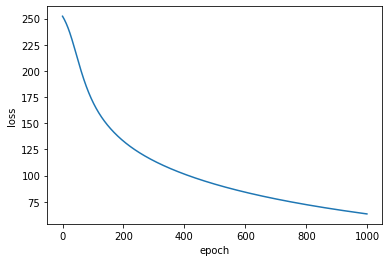

In [ ]:
plt.plot(losses, label = "train")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
y_hat = mmodel.predict(x_train_tf, y_train)
print(y_hat)

[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 

training set의 분류 정확도는 0.98이다.

In [ ]:
score = 0.0

for i in range(0, len(y_train)-1):
  if y_hat[i] == y_train[i]:
    score = score + 1
    
score = score/len(y_train)

print("score is ", score)

score is  0.9835164835164835


이제 전혀 다른 방법으로 
**상기과정을 Sequential Model로 전환하여 시행해 본다**
**데이터 관점에서 보면 Sequential Model을 사용할 경우 X data를 numpy로 그냥 써도 된다  **
**고수준 모델에서는 Class를 사용하지 않고 일반적인 함수로도 충분하다**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt



from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y,test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)
y_train = y_train.reshape(364,1)
print(x_train.shape)


(364, 30) (364,)
(364, 30)


여기서는 x_train_centered를 tf.Variable로 전환하지 않았다.

In [ ]:
mean_vals = np.mean(x_train, axis=0) 
std_val = np.std(x_train, axis=0)
x_train_centered = (x_train - mean_vals) / std_val

In [ ]:
model = tf.keras.models.Sequential()

**이전 모델과의 차이점은 weight의 초기치를 glorot_uniform을 쓴다는 것이다.**
 초기값의 기본설정은 다음과 같다 kernel_initializer='glorot_uniform'
activation이 옵션으로는 relu, softmax, sigmoid, tanh 등이 있다.



In [ ]:
model.add(tf.keras.layers.Dense(
    units=20,
    input_dim=x_train_centered.shape[1],
    #kernel_initializer='glorot_uniform',
    kernel_initializer='zero',
    bias_initializer='zero',
    activation ="sigmoid"))

model.add(tf.keras.layers.Dense(
    units=y_train.shape[1],
    input_dim=20,
    #kernel_initializer='glorot_uniform',
    kernel_initializer='zero',
    bias_initializer='zero',
    activation = "sigmoid"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy')

In [ ]:
history = model.fit(x_train, y_train, epochs=1000)

Epoch 1/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.6822
Epoch 2/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.6553
Epoch 3/1000
12/12 [==============================] - 0s 1ms/step - loss: 0.6133
Epoch 4/1000
12/12 [==============================] - 0s 1ms/step - loss: 0.5779
Epoch 5/1000
12/12 [==============================] - 0s 1ms/step - loss: 0.5457
Epoch 6/1000
12/12 [==============================] - 0s 1ms/step - loss: 0.5131
Epoch 7/1000
12/12 [==============================] - 0s 1ms/step - loss: 0.4969
Epoch 8/1000
12/12 [==============================] - 0s 1ms/step - loss: 0.4849
Epoch 9/1000
12/12 [==============================] - 0s 2ms/step - loss: 0.4678
Epoch 10/1000
12/12 [==============================] - 0s 1ms/step - loss: 0.4545
Epoch 11/1000
12/12 [==============================] - 0s 1ms/step - loss: 0.4477
Epoch 12/1000
12/12 [==============================] - 0s 1ms/step - loss: 0.4649
Epoch 13/1000
12/12 [====

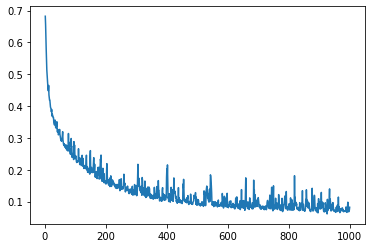

In [ ]:
epochs = np.arange(1, 1000+1)
plt.plot(epochs, history.history['loss'])

model.predict는 값자체를 예측하고, model.predict_classes는 1,0 등 분류데이터로 예측을 한다.

In [ ]:
y_train_pred = model.predict_classes(x_train_centered) 

In [ ]:
correc_preds = np.sum(y_train == y_train_pred, axis=0)

In [ ]:
print("정확도는  ", correc_preds / y_train.shape[0])

정확도는   [0.89285714]


In [ ]:
model.save_weights('mlp_weight.h5')

In [ ]:
W_Input_Hidden = model.layers[0].get_weights()[0] # 첫번째 Layer의 weight를 가져오는 방법이다.

In [ ]:
print(W_Input_Hidden)

[[-2.48989433e-01 -4.84146886e-02  1.68191075e-01  1.44767821e-01
   2.41171062e-01 -3.50050330e-02  2.27494746e-01  3.09381187e-02
   1.03873074e-01 -1.07410744e-01  2.66996115e-01  2.06619993e-01
   2.81836212e-01  3.10609996e-01  3.23907018e-01  1.33269042e-01
   3.26643348e-01 -1.07562467e-01 -2.34670505e-01 -1.56586021e-01]
 [-3.38367760e-01 -1.13012508e-01 -3.00682217e-01 -2.33388126e-01
   1.83026955e-01  2.11466551e-02  1.55122757e-01  5.39049208e-02
  -2.60606170e-01 -3.16739798e-01  5.36584035e-02 -1.09058142e-01
   2.04704404e-01  1.70388341e-01 -2.08519921e-01  2.67397225e-01
   1.87040687e-01 -1.95498273e-01  1.12425745e-01 -2.39749908e-01]
 [ 1.68604124e-02 -3.24964583e-01  3.27028453e-01  2.57922053e-01
   1.26956642e-01  2.71367192e-01  1.30686283e-01 -1.54437929e-01
  -2.73438543e-01  1.16188645e-01 -1.32074272e-02  2.03805089e-01
   1.88692451e-01 -2.47932076e-02 -1.25590757e-01  2.76374519e-02
  -2.64285594e-01 -1.82769239e-01  1.47345960e-01  2.26954401e-01]
 [-2.83

In [ ]:
print(model.layers[0].get_weights()[1])  # 첫번째 Layer의 bias 를 가져오는 방법이다.

[-6.4430618e-01 -8.1603396e-01  0.0000000e+00  1.2230252e-07
 -7.1575880e-07 -7.5524014e-28 -2.2723086e-02  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -4.8475772e-02 -5.6603275e-02
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -1.1057972e-18  0.0000000e+00 -2.8524427e-15]
